# Insert worm

In [1]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon
from scipy.integrate import quad, simps

### Simulation parameters

In [2]:
# Simulation parameters
N = 4
L = N   # half-filling
t = 0
U = 3
mu = -0.1
    
# PIMC parameters
beta = 1
eta = 1/np.sqrt(L*beta)      # worm end fugacity

### Create a worldline configuration 

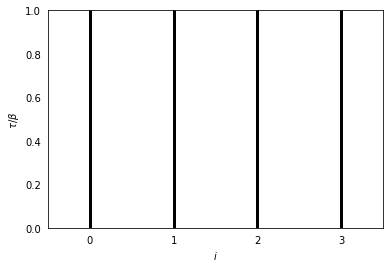

In [3]:
# Create a worldline configuration
alpha = [2,2,2,2]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Insert a worm or antiworm

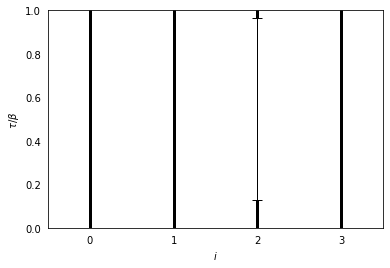

head_loc:  [2, 1]
tail_loc:  [2, 2]


In [4]:
# Create a worldline configuration
alpha = [2,2,2,2]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []

pimc.worm_insert(data_struct,beta,head_loc,tail_loc,U,mu,eta)

pimc.view_worldlines(data_struct,beta,figure_name=None)
print("head_loc: ",head_loc)
print("tail_loc: ",tail_loc)

In [5]:
# Do insert many times on the above configuration
mc_steps = int(1E+05)
worm_lengths = np.zeros(mc_steps)  # create array to save worm lengths
accepted = 0
rejected = 0
r_list = []
for m in range(mc_steps):
    
    pimc.worm_insert(data_struct,beta,head_loc,tail_loc,U,mu,eta)

    #[time,N,(src,dest)]
    tau_h = data_struct[head_loc[0]][head_loc[1]][0]
    tau_t = data_struct[tail_loc[0]][tail_loc[1]][0]
    worm_length = tau_h-tau_t
    
    # Worm length correction if antiworm is present
    if worm_length < 0:
        worm_length = -worm_length
        
    worm_lengths[m] = worm_length
    
    # Count accepted updates  
    if tau_h != data_struct[head_loc[0]][head_loc[1]][0] or (
       tau_t != data_struct[tail_loc[0]][tail_loc[1]][0] ):
        accepted += 1

    # Count rejected updates  
    if tau_h == data_struct[head_loc[0]][head_loc[1]][0] and (
       tau_t == data_struct[tail_loc[0]][tail_loc[1]][0] ):
        rejected += 1
        
    if m == mc_steps - 1: break
        
    # Create a worldline configuration
    alpha = [2,2,2,2]
    data_struct = pimc.create_data_struct(alpha)
    head_loc = []
    tail_loc = []
    
# Print the number of accepted time shifts
print("Accepted: %.4f %%"%(accepted/mc_steps*100))
print("Rejected: %.4f %%"%(rejected/mc_steps*100))

Accepted: 0.0000 %
Rejected: 100.0000 %


In [8]:
# Histogram of worm lengths
b = beta
loc = 0

# Calculate change in diagonal energy after/before worm end (need this for scale)
x = head_loc[0]
k = head_loc[1]
n_f = data_struct[x][k][1]       # particles after head
n_o = data_struct[x][k-1][1]     # particles before head
dV = (U/2)*(n_o*(n_o-1)-n_f*(n_f-1)) - mu*(n_o-n_f)

scale = 1/abs(dV)
print("scale: ",scale)
# Generate truncated exponential distribution of worm lengths
tau_w = np.linspace(0,beta,int(1E+02+1))                    # worm lengths
tau_w = (tau_w[1:]+tau_w[0:-1])/2
pdf = truncexpon.pdf(tau_w,b=b/scale,loc=loc,scale=scale)
if tau_h - tau_t < 0:
    pdf = truncexpon.pdf(-tau_w+b,b=b/scale,loc=loc,scale=scale)

# Rescale & normalize the truncated exponential pdf
#if tau_t < tau_h:
#    pdf *= (beta-tau_w)     # worm
#else:
#    pdf *= (tau_w)           # antiworm?
pdf /= simps(pdf,tau_w)

#pdf_1 = pdf*(beta-tau_w)
#pdf_1 /= simps(pdf_1,tau_w)
#pdf_2 = pdf*(tau_w)
#pdf_2 /= simps(pdf_2,tau_w)
#pdf_3 = ( pdf_1  + pdf_2 ) / simps(pdf_1+pdf_2,tau_w)

# Sampled worm lengths
n, bins = np.histogram(worm_lengths, bins=tau_w, density=1) # for histogram

scale:  0.3225806451612903


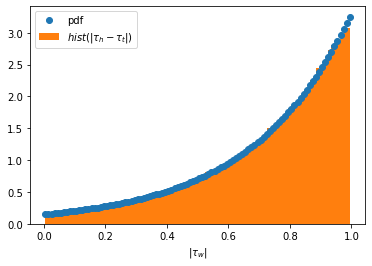

In [9]:
# Plot
fig, ax = plt.subplots(1, 1)
ax.plot(tau_w,pdf,label='pdf',linestyle='None',marker='o')
ax.hist(worm_lengths,bins=bins,density=True,histtype='stepfilled',alpha=1,label=r'$hist(\vert\tau_h-\tau_t\vert)$')
ax.set_xlabel(r"$\vert \tau_w \vert $") ;
#ax.set_yscale("log");
plt.legend() ;
#plt.savefig("antiworm_%d_%d_%.4f_%.4f_%.4f_%d.pdf"%(L,N,U,mu,t,mc_steps))